### Load Libraries

In [153]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import utils

from nixtlats import TimeGPT
from nixtlats.date_features import CountryHolidays
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

load_dotenv()

True

### Assess if our TimeGPT token is valid

In [9]:
timegpt = TimeGPT(token = os.environ.get("TIMEGPT_KEY"))
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

### Data:
- Target variable column cannot have missing or non-numeric values.
- The dataset cannot have jumps in the datestamps between the first and last datestamp.
- The model does not fill missing values.
- The date column should be readable by Pandas.
- The data does not need to be normalized, the model takes care of it.
- For multi time series forecasting the dataset must have a column that identifies each time series which is then passed as an argument to the forecast function.
- For exogenous features, we must have a separate data frame with those features for the forecast horizon.

In [79]:
# read data frame and parse dates as datetime
df = pd.read_csv('data/data.csv', parse_dates=['delivery_week'])

# create a masked df due to confidential data
masked_df = df.copy()
masked_df[['target', 'marketing_events_1', 'marketing_events_2']] = MinMaxScaler().fit_transform(masked_df[['target', 'marketing_events_1', 'marketing_events_2']])
masked_df[['unique_id']] = OrdinalEncoder().fit_transform(masked_df[['unique_id']])

print(f"Distinct number of time series: {len(masked_df['unique_id'].unique())}")
masked_df.head()

Distinct number of time series: 195


,unique_id,delivery_week,country,target,marketing_events_1,marketing_events_2
0,0.0,2018-12-31,us,0.017484,0.072103,0.262909
1,0.0,2019-01-07,us,0.026652,0.042019,0.456050
2,0.0,2019-01-14,us,0.025160,0.040776,0.407437
3,0.0,2019-01-21,us,0.027505,0.040030,0.368940
4,0.0,2019-01-28,us,0.028571,0.034063,0.339640


### Add seasonal binary variables

In [80]:
df['week'] = df['delivery_week'].dt.isocalendar().week
df['month'] = df['delivery_week'].dt.month

df = pd.get_dummies(df, columns=['week', 'month'], dtype=int)

### Split data between train and test

In [82]:
# Let's use the last 17 weeks of actuals as of today for the holdout set and the remaining data for the forecast
forecast_df = df[df['delivery_week'] < "2023-10-16"]
holdout_df = df[(df['delivery_week'] >= "2023-10-16") & (df['delivery_week'] <= "2024-02-05")]

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Weeks for training: {len(forecast_df['delivery_week'].unique())} from {min(forecast_df['delivery_week']).date()} to {max(forecast_df['delivery_week']).date()}")
print(f"Weeks for testing: {len(holdout_df['delivery_week'].unique())} from {min(holdout_df['delivery_week']).date()} to {max(holdout_df['delivery_week']).date()}")

Weeks for training: 250 from 2018-12-31 to 2023-10-09
Weeks for testing: 17 from 2023-10-16 to 2024-02-05


### Forecast

In [86]:
# create list with seasonal exogenous features
EXOGENOUS_FAETURES = [x for x in df.columns if ('week_' in x) | ('month_' in x)]

timegpt_fcst_ex_vars_df = timegpt.forecast(
    df=forecast_df[['unique_id', 'delivery_week', 'target', 'marketing_events_1', 'marketing_events_2']+EXOGENOUS_FAETURES], # data to forecast
    time_col='delivery_week', # date column
    target_col='target', # column to forecast
    X_df=holdout_df[['unique_id', 'delivery_week', 'marketing_events_1', 'marketing_events_2']+EXOGENOUS_FAETURES], # exogenous features in the forecast horizon
    date_features=[CountryHolidays(['US'])], # holidays
    h=17, # forecats horizon
    level=[80], # confidence intervals
    freq='W-MON', # frequency of series 
    id_col='unique_id', # series id
    model='timegpt-1', # use timegpt-1-long-horizon for more than one seasonal period
    add_history=True, # returns fitted values of the model
    )

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: marketing_events_1, marketing_events_2, week_1, week_2, week_3, week_4, week_5, week_6, week_7, week_8, week_9, week_10, week_11, week_12, week_13, week_14, week_15, week_16, week_17, week_18, week_19, week_20, week_21, week_22, week_23, week_24, week_25, week_26, week_27, week_28, week_29, week_30, week_31, week_32, week_33, week_34, week_35, week_36, week_37, week_38, week_39, week_40, week_41, week_42, week_43, week_44, week_45, week_46, week_47, week_48, week_49, week_50, week_51, week_52, week_53, month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12, US_Martin Luther King Jr. Day, US_Washington's Birthday, US_Columbus Day, US_New Year's Day, US_Memorial Day, US_Independence Day, US_Labor Day, US_Veterans Day, US_Veterans Day (Observed), US_Thanksgiving, US_Christmas Day, 

#### Plot Importance of Exogenous Features

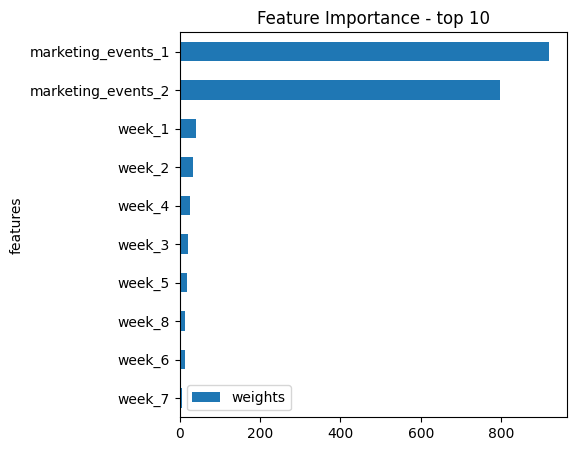

In [110]:
timegpt.weights_x.head(10).sort_values(by='weights').plot.barh(x='features', y='weights')
plt.title('Feature Importance - top 10')
plt.show()

#### Plot Actuals and Forecast

In [ ]:
# get series ordered by volume in a descending way
series = holdout_df.groupby('unique_id')['target'].sum().reset_index().sort_values(by='target', ascending=False)['unique_id'].tolist()

timegpt.plot(
    forecast_df[['unique_id', 'delivery_week', 'target']], 
    timegpt_fcst_ex_vars_df,
    time_col='delivery_week',
    target_col='target',
    unique_ids=series[:6],
    level=[80], 
)

### Model Evaluation

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


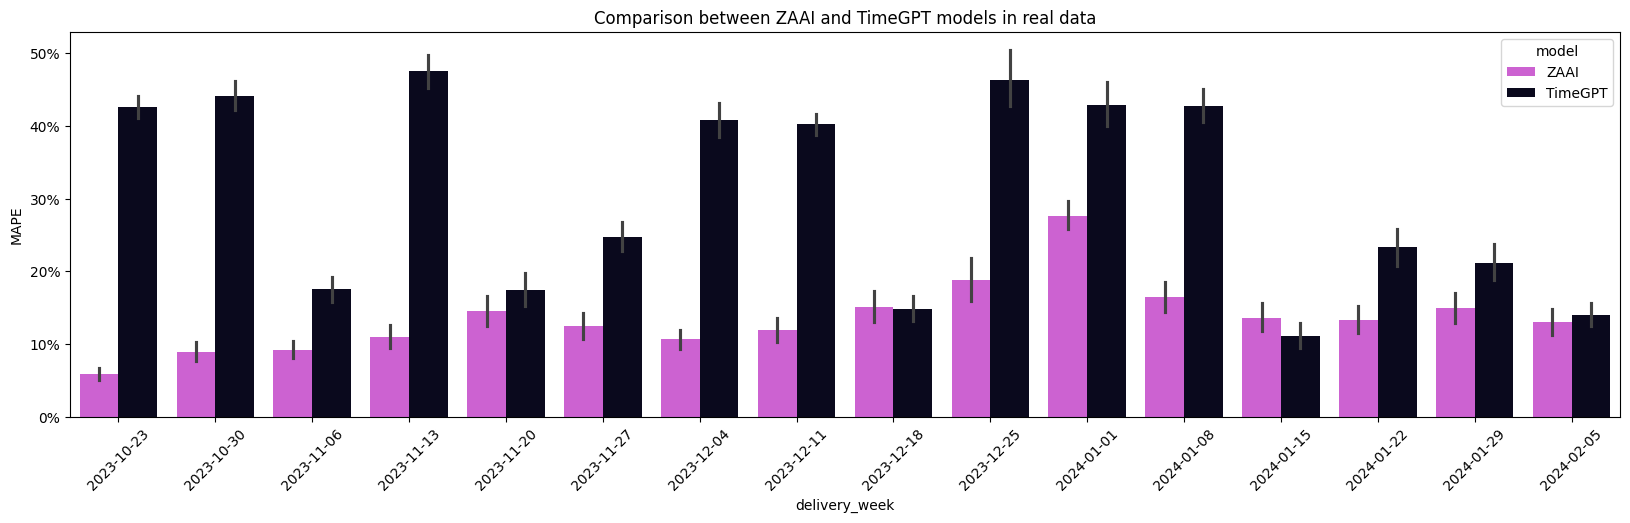

In [150]:
# load the forecast from our current model in production
zaai_model_df = pd.read_csv('data/zaai_model.csv', parse_dates=['delivery_week'])

# merge data frames with zaai forecast and actuals
model_eval_df = pd.merge(holdout_df[['unique_id', 'delivery_week', 'target']], zaai_model_df[['unique_id', 'delivery_week', 'forecast']], on=['unique_id', 'delivery_week'], how='inner')

# merge data frames with TimeGPT forecast and actuals
timegpt_fcst_ex_vars_df['delivery_week'] = pd.to_datetime(timegpt_fcst_ex_vars_df['delivery_week'])
model_eval_df = pd.merge(model_eval_df, timegpt_fcst_ex_vars_df[['unique_id', 'delivery_week', 'TimeGPT']], on=['unique_id', 'delivery_week'], how='inner')

utils.plot_model_comparison(model_eval_df)